# Using NLP to process sci-fi robotics’ father work


In [1]:
import re

import pandas as pd
import numpy as np
import math
# from collections import defaultdict

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 10)

# nltk
from nltk import tokenize



# Plotting tools

from tqdm import tqdm_notebook as tqdm
from tqdm import trange

## Data modeling

In [2]:
class TextChunk:
    
    def __init__(self, start, end, title='', idx=-1):
        self.start = start
        self.end = end
        self.title = title
        self.subs = []
        self.idx = idx
        
    def __iter__(self):
        return iter(self.subs)
    
    def __repr__(self):
        return f'{self.title} @ [{self.start}:{self.end}]'
    
    def __getitem__(self, key):
        return self.subs[key]
    
def split_chunk(raw_series, chunk, regex, title_f=lambda m: m.groups()[-1], length_ration_threshold=0):

    regex = f'\s*{regex}\s*'
    subs = [['', chunk.start, chunk.start]]

    while subs[-1][2] < chunk.end:
        m = re.search(regex, raw_series[subs[-1][2]:chunk.end], flags=re.MULTILINE)
        
        if m:
            _start = m.start() + subs[-1][2]
            _end = m.end() + subs[-1][2]
            
            if  _start - subs[-1][1] > length_ration_threshold * (chunk.end - chunk.start):
                subs[-1][2] = _start
            else:
                del subs[-1]
                                                                  
            
            subs.append([title_f(m), _end, _end])
        else:
            subs[-1][2] = chunk.end
            
        
    
    chunks = [TextChunk(sub[1], sub[2], title=sub[0]) for sub in subs if sub[2] - sub[1] > length_ration_threshold * (chunk.end - chunk.start)]
    
            
    return [TextChunk(sub[1], sub[2], title=sub[0], idx=idx) for idx, sub in enumerate(subs)]
        
def chunk_sentences(chunk, text):
    chunk_text = text[chunk.start:chunk.end]
    lines = [line.strip() for line in re.split('([^\S\r\n]?\n[^\S\r\n]?){2,}', chunk_text)]
    return [re.sub('\s+', ' ', line) for line in lines if line]

def chunk_apply(chunk, func, target_depth=0, group_depth=-1):
    
    if target_depth == 0:
        res = [func(chunk)]
    else:
        res = [cres for child in chunk for cres in chunk_apply(child, func, target_depth - 1, group_depth - 1)]
        
    if group_depth == 0:
        return [(chunk, res)]
    else:
        return res
    
def chunk_apply_group_labes(chunk, func, target_depth, group_depth):
    res = chunk_apply(chunk, func, target_depth, group_depth)
    
    labels = []
    values = []
    
    s = 0
    for _chunk, _values in res:
        e = s + len(_values)
        labels.append((_chunk.title, (s, e)))
        values += _values
        s = e
    
    return labels, values

### Data reading

In [3]:
def chapter_title(match):
    t = match.group(2)
    if not t:
        t = match.group(3)
    if not t:
        t = ''
        
    return f'{match.group(1)} {t}'.strip()

with open('data/the_foundation_asimov.raw.txt') as file:
    lines = file.readlines()
    
with open('data/the_foundation_asimov.raw.txt') as file:
    raw_series = file.read()
    a = len(raw_series)
    raw_series = re.sub(r'^i(\s*.\s*$)', r'1\1', raw_series, flags=re.MULTILINE)
    raw_series = re.sub(r'(\S)[^\S\r\n]*\n[^\S\r\n]*(\S)', r'\1\n\2', raw_series)
    raw_series = re.sub(r'(?:[^\S\r\n]+\n[^\S\r\n]*)|(?:[^\S\r\n]*\n[^\S\r\n]+)', r'\n', raw_series, flags=re.MULTILINE)
    raw_series = re.sub(r'([^\.\s(\.\")\?\!\-\d])\s*\n\s*(?:\n\s*){2,}\s*', r'\1 \n', raw_series, flags=re.MULTILINE)
    raw_series = re.sub(r'([^\S\r\n]?\n[^\S\r\n]?){3,}', '\n\n', raw_series, flags=re.MULTILINE)

series = TextChunk(0, len(raw_series), title='Foundation series')
series.subs = split_chunk(raw_series, TextChunk(0, len(raw_series)), '([A-Z ]*[A-Z])\s*\n\s*ISAAC ASIMOV')
for book in series.subs:
    book.subs = split_chunk(raw_series, book, 'PART ([IVX]*)\s*([A-Z ]*)', title_f=lambda m: f'{m.group(1):3} {m.group(2)}', length_ration_threshold=0.05)
    for part in book.subs:
        part.subs = split_chunk(raw_series, part, '^([\d]+)\s*(?:(?:\.\s(?:([A-Z ]*[A-Z])\s*)?\s*)|(?:\n\s*([^\n]*\S)\s*))$', title_f=chapter_title, length_ration_threshold=0.01)
        
series.subs = series.subs[1:]

In [4]:
def extract_dataframe(chunk, func, target_depth, group_depth):
    
    _func = lambda c:(c.title, func(c))
    
    data = {'group': [], 'label': [], 'value': []}
    tmp = chunk_apply(chunk, _func, target_depth, group_depth)
    
    for _chunk, _values in tmp:
        for _value in _values:
            data['group'].append(_chunk.title)
            data['label'].append(_value[0])
            data['value'].append(_value[1])
            
    return pd.DataFrame(data=data)

series_df = extract_dataframe(series, lambda c: ' '.join(chunk_sentences(c, raw_series)), target_depth=3, group_depth=2)

## Plot utilities

In [5]:
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline
tab10 = matplotlib.cm.get_cmap('tab10')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def plot_sentiment(labels, values, title=None, show=True, save_dest=None):
    
    length = len(values)

    x = np.linspace(0, length - 1, num=length)
    y = values

    plt.figure(figsize=(15, 10))
    for label, _range in labels:
        s, e = _range
        plt.plot(x[s:e], y[s:e], label=label)
            
    plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label = 'Moving Average')
    plt.axhline(y=0, xmin=0, xmax=length, alpha=.25, color='r', linestyle='--', linewidth=3)
    plt.legend(loc='best', fontsize=15)
    if title:
        plt.title(title, fontsize=20)
    plt.xlabel('Chapter', fontsize=15)
    plt.ylabel('Average Sentiment', fontsize=15)
    
    if save_dest:
        plt.savefig(save_dest, facecolor='white', transparent=True, bbox_inches='tight')
    elif show:
        plt.show()
    else:
        return plt

In [6]:
def plot_multiple_emotions_window(df, legend, emotions, window=5, title=None, show=True, save_dest=None):
    
    length = len(df)
    
    x = np.linspace(0, length - 1, num=length)[int(window / 2): -int(window / 2)]

    fig = plt.figure(figsize=(15, 15))
    ax =fig.add_subplot(1, 1, 1)

    for c, emotion in enumerate(emotions):
        y = movingaverage([row[emotion] for _, row in df.iterrows()], window)[int(window / 2): -int(window / 2)]
        plt.plot(x, y, linewidth=5, label=emotion, color=(tab10(c)))

    _ticks = []
    _labels = []

    for _label, _range in legend:
        s, e = _range
        _ticks.append((s + e)/2)
        _labels.append(_label)
        plt.axvline(x=s, color='black', linewidth=2, linestyle=':')
    plt.axvline(x=length - 1, color='black', linewidth=2, linestyle=':')

    plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))
    if title:
        plt.title(title, fontsize=20)
    plt.ylabel('Relative Sentiment', fontsize=15)
    plt.xticks(_ticks, _labels, rotation=-30, fontsize=15, ha='left')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::1], labels[::1], loc='best', fontsize=15, bbox_to_anchor=(1.2, 1))

    ax.grid(False)

    if save_dest:
        plt.savefig(save_dest, facecolor='white', transparent=True, bbox_inches='tight')
    elif show:
        plt.show()
    else:
        return plt

In [7]:
def subplot_multiple_emotions(df, legend, emotions, suptitle=None, show=True, save_dest=None):
    length = len(df)
    
    x = np.linspace(0, length - 1, num=length)
    
    rows = math.ceil(len(emotions) / 3)
    if rows * 3 == len(emotions):
        rows += 1

    fig, ax = plt.subplots(rows, 3, figsize=(15, rows*3 + 1), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.1)
    if suptitle:
        fig.suptitle(suptitle, fontsize=20, y=1.02)
    fig.subplots_adjust(top=0.88)

    ax = ax.ravel()

    for i, emotion in enumerate(emotions):
        y = [row[emotion] for _, row in df.iterrows()]

        for label, _range in legend:
            s, e = _range
            ax[i].plot(x[s:e], y[s:e], label=label, linewidth=2)

        ax[i].set_title('{} Sentiment'.format(emotion.title()))
        ax[i].set_xticks([])
        
    legend_x = {
        2: .97,
        1: .85,
        0: .65
    }[len(emotions) % 3]

    fig.legend([label for label, _ in legend], loc='upper right', fontsize=15, bbox_to_anchor=(legend_x, .235))
    fig.tight_layout()
    
    for i in range(3 - len(emotions) % 3):
        fig.delaxes(ax[-1-i])
    
    if save_dest:
        plt.savefig(save_dest, facecolor='white', transparent=True, bbox_inches='tight')
    elif show:
        plt.show()
    else:
        return plt

## Cross techniquetools

In [8]:
def avg_emotions(source_df, vectors_df, preprocessing_func=lambda x: x):

    new_df = source_df.copy()
    emotions = vectors_df.columns
    
    if 'word' in emotions:
        emotions.drop('word')
        
    length = len(list(new_df.iterrows()))
    groups_legend = []
    group = ''
    
    emo_df = pd.DataFrame(0, index=source_df.index, columns=emotions)
    
    with tqdm(total=length) as pbar:
        for i, row in new_df.iterrows():
            if row['group'] != group:
                if groups_legend:
                    groups_legend[-1] = (groups_legend[-1][0], (groups_legend[-1][1][0], i))
                groups_legend.append((row['group'], (i, length)))
                group = row['group']
            pbar.update(1)
            doc = [preprocessing_func(w.lower()) for w in word_tokenize(new_df.loc[i]['value'])]
            doc_vec = [vectors_df.loc[w] if w in vectors_df.index else pd.Series(0, emotions) for w in doc]
            emo_score = pd.DataFrame(data = doc_vec).mean()
            emo_df.loc[i] = emo_score
            
    new_df = pd.concat([new_df, emo_df], axis=1)
    new_df.set_index(['group', 'label'], inplace=True)

    return (groups_legend, new_df)

## Vader

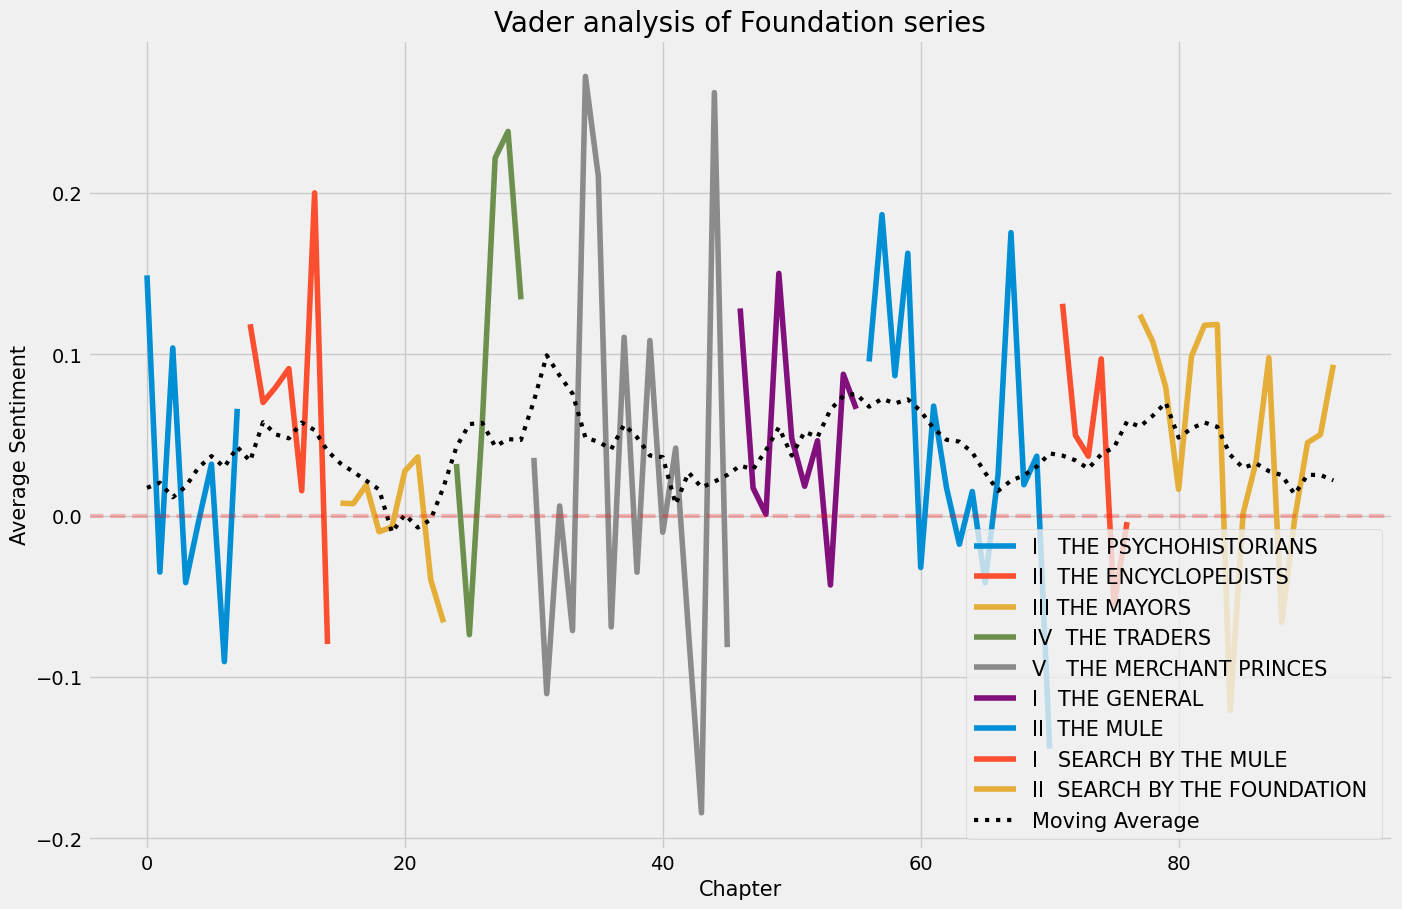

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def vader_avg(chunk):
    sentences = chunk_sentences(chunk, raw_series)
    
    analyzer = SentimentIntensityAnalyzer()

    sent = {
        'neg': .0,
        'neu': .0,
        'pos': .0,
        'compound': .0}
    
    
    for sentence in sentences:
        _s = analyzer.polarity_scores(sentence)
        
        for k in sent:
            sent[k] += _s[k]
            
    for k in sent:
        sent[k] = round(sent[k] / len(sentences), 5)
        
    return sent

labels, values = chunk_apply_group_labes(series, vader_avg, 3, 2)
vader_sentiments = [val['compound'] for val in values]
plot_sentiment(labels, vader_sentiments, title=f'Vader analysis of {series.title}')

## NRC Emotion

In [10]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer


stemmer = SnowballStemmer("english")

nrc_vec = pd.read_csv('NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', names=["word", "emotion", "association"], sep='\t')
nrc_vec = nrc_vec.pivot(index='word', columns='emotion', values='association').reset_index()
nrc_emotions = nrc_vec.columns.drop('word')
nrc_vec = nrc_vec.set_index('word')

In [11]:
legend, nrc_df = avg_emotions(series_df, nrc_vec, stemmer.stem)

  0%|          | 0/93 [00:00<?, ?it/s]

In [12]:
nrc_df['rel_sentiment'] = nrc_df['positive'] - nrc_df['negative']
nrc_relative_sentiment = [row['rel_sentiment'] for _, row in nrc_df.iterrows()]
pd.Series(vader_sentiments).corr(pd.Series(nrc_relative_sentiment))

0.5041716261684067

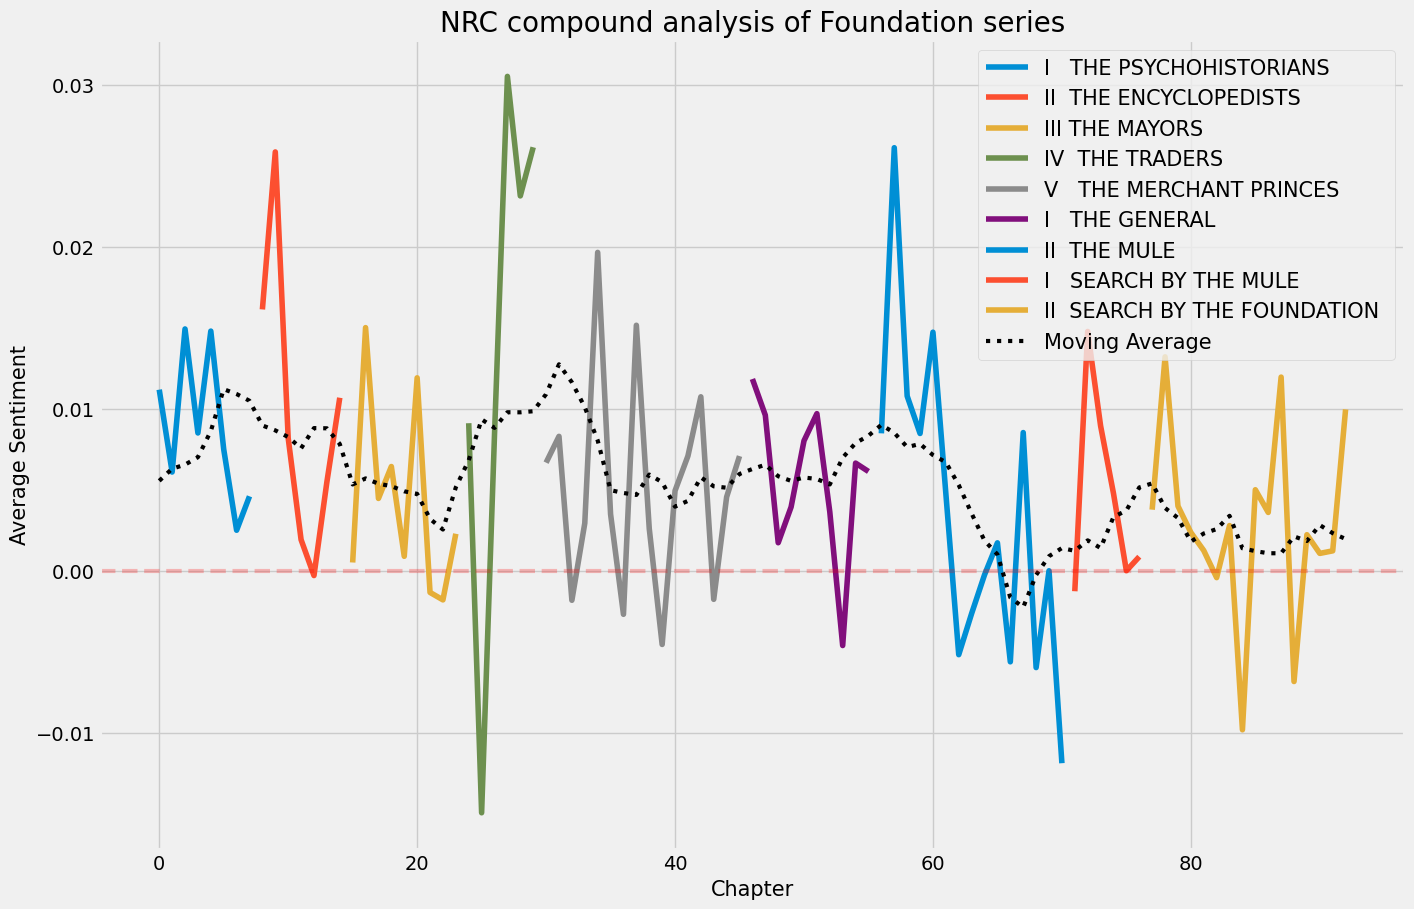

In [13]:
plot_sentiment(labels, nrc_relative_sentiment, title=f'NRC compound analysis of {series.title}')

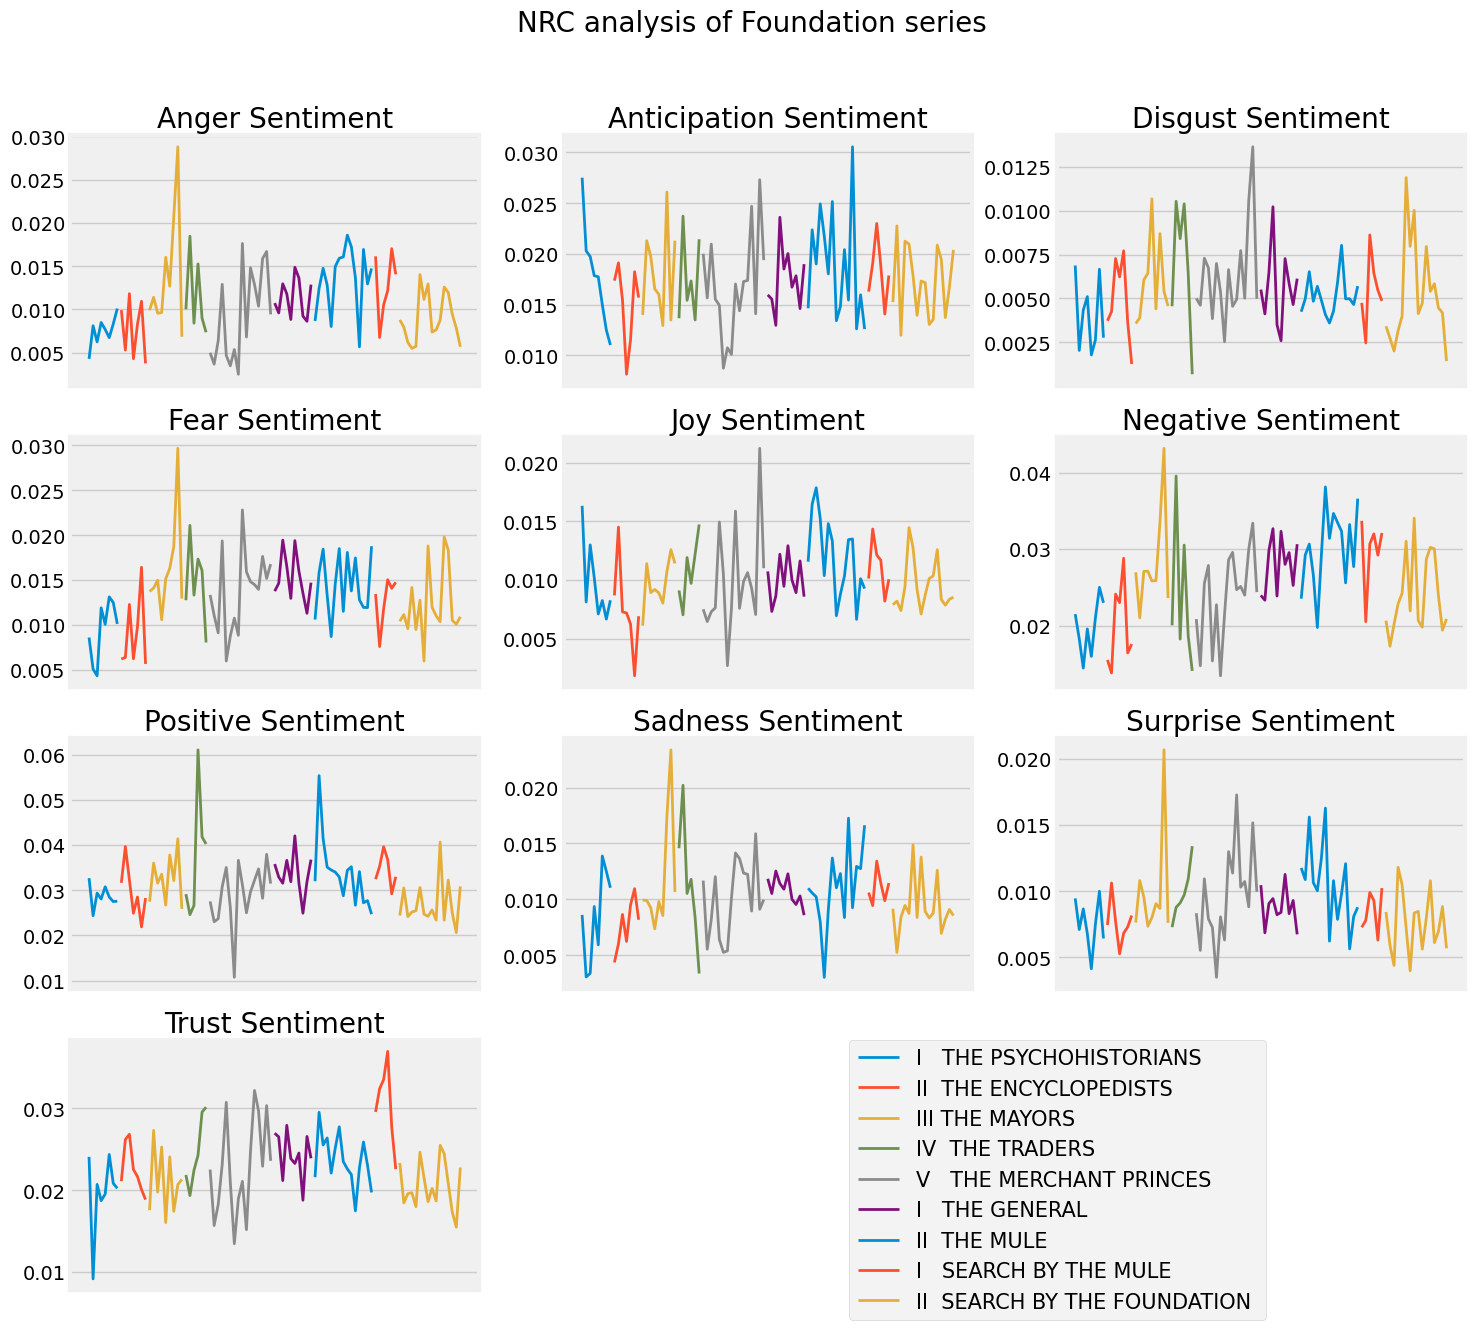

In [14]:
subplot_multiple_emotions(nrc_df, legend, nrc_emotions,  suptitle=f'NRC analysis of {series.title}')

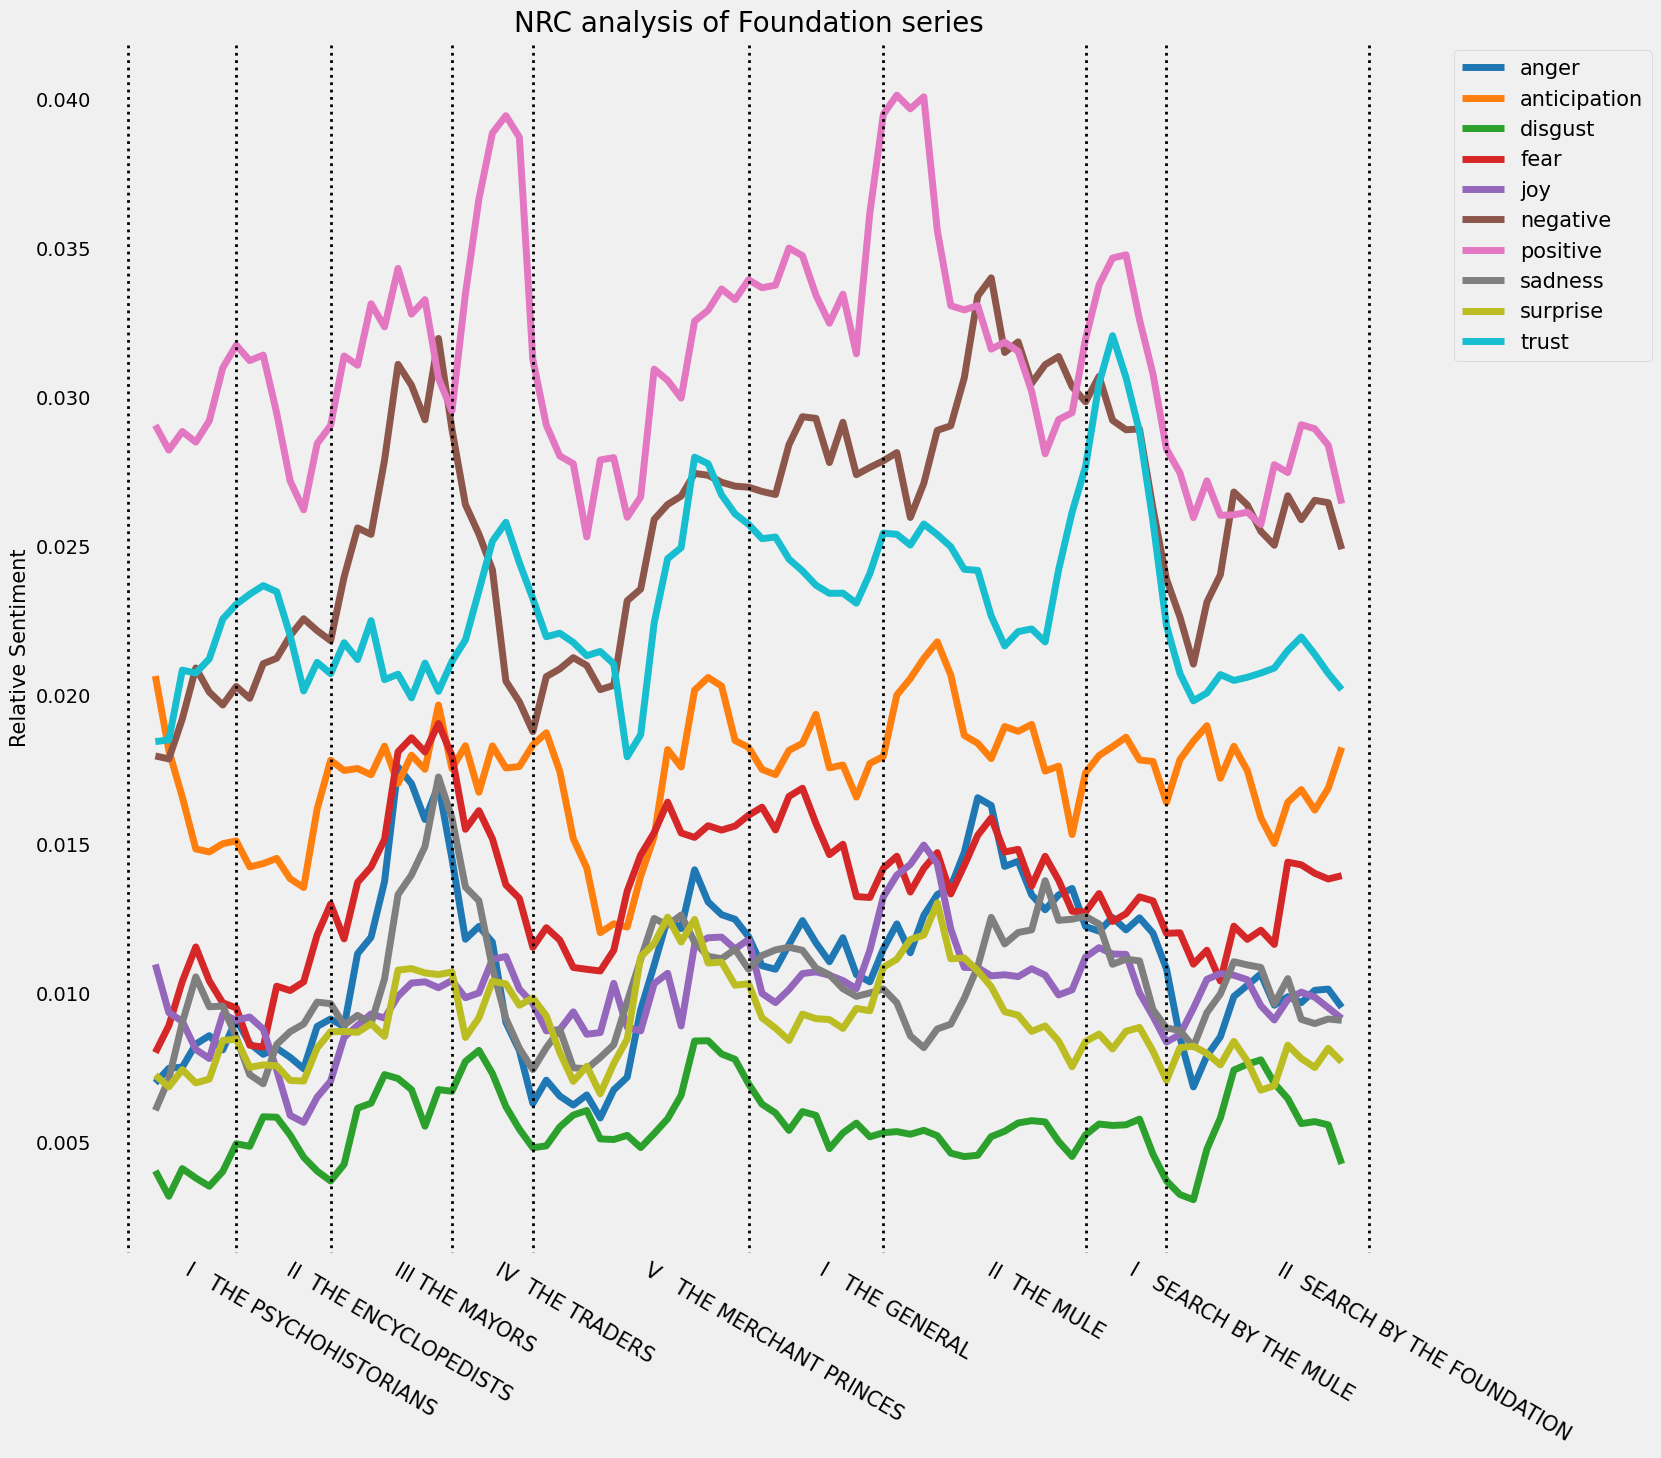

In [15]:
plot_multiple_emotions_window(nrc_df, legend, nrc_emotions, title=f'NRC analysis of {series.title}')

## SentiArt

In [16]:
import os,codecs
import pandas as pd
import nltk
from nltk import*
import matplotlib.pyplot as plt

In [17]:
TC = 'SentiArt/250kSentiArt_EN.csv'
sa_vector = pd.read_csv(TC, usecols=['word', 'AAPz', 'ang_z', 'disg_z', 'fear_z', 'hap_z', 'sad_z', 'surp_z'])
sa_vector.columns = ['word', 'valence', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
sa_vector = sa_vector.set_index('word')

sa_emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [18]:
legend, sa_df = avg_emotions(series_df, sa_vector, stemmer.stem)

  0%|          | 0/93 [00:00<?, ?it/s]

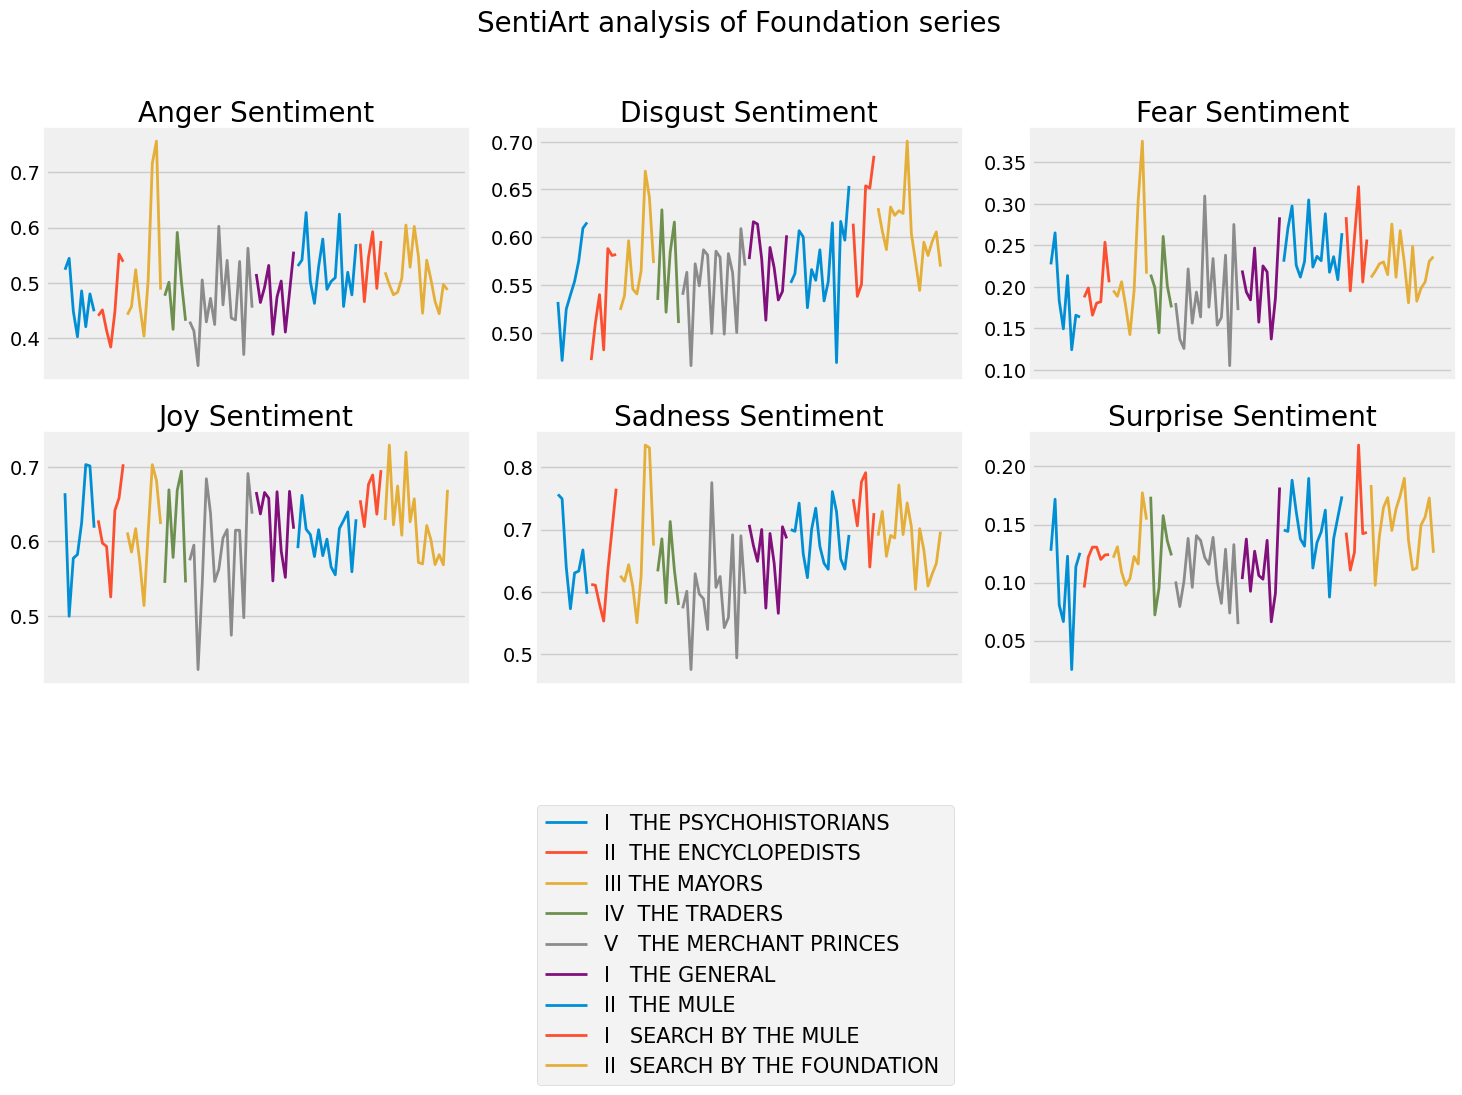

In [19]:
subplot_multiple_emotions(sa_df, legend, sa_emotions, suptitle=f'SentiArt analysis of {series.title}')

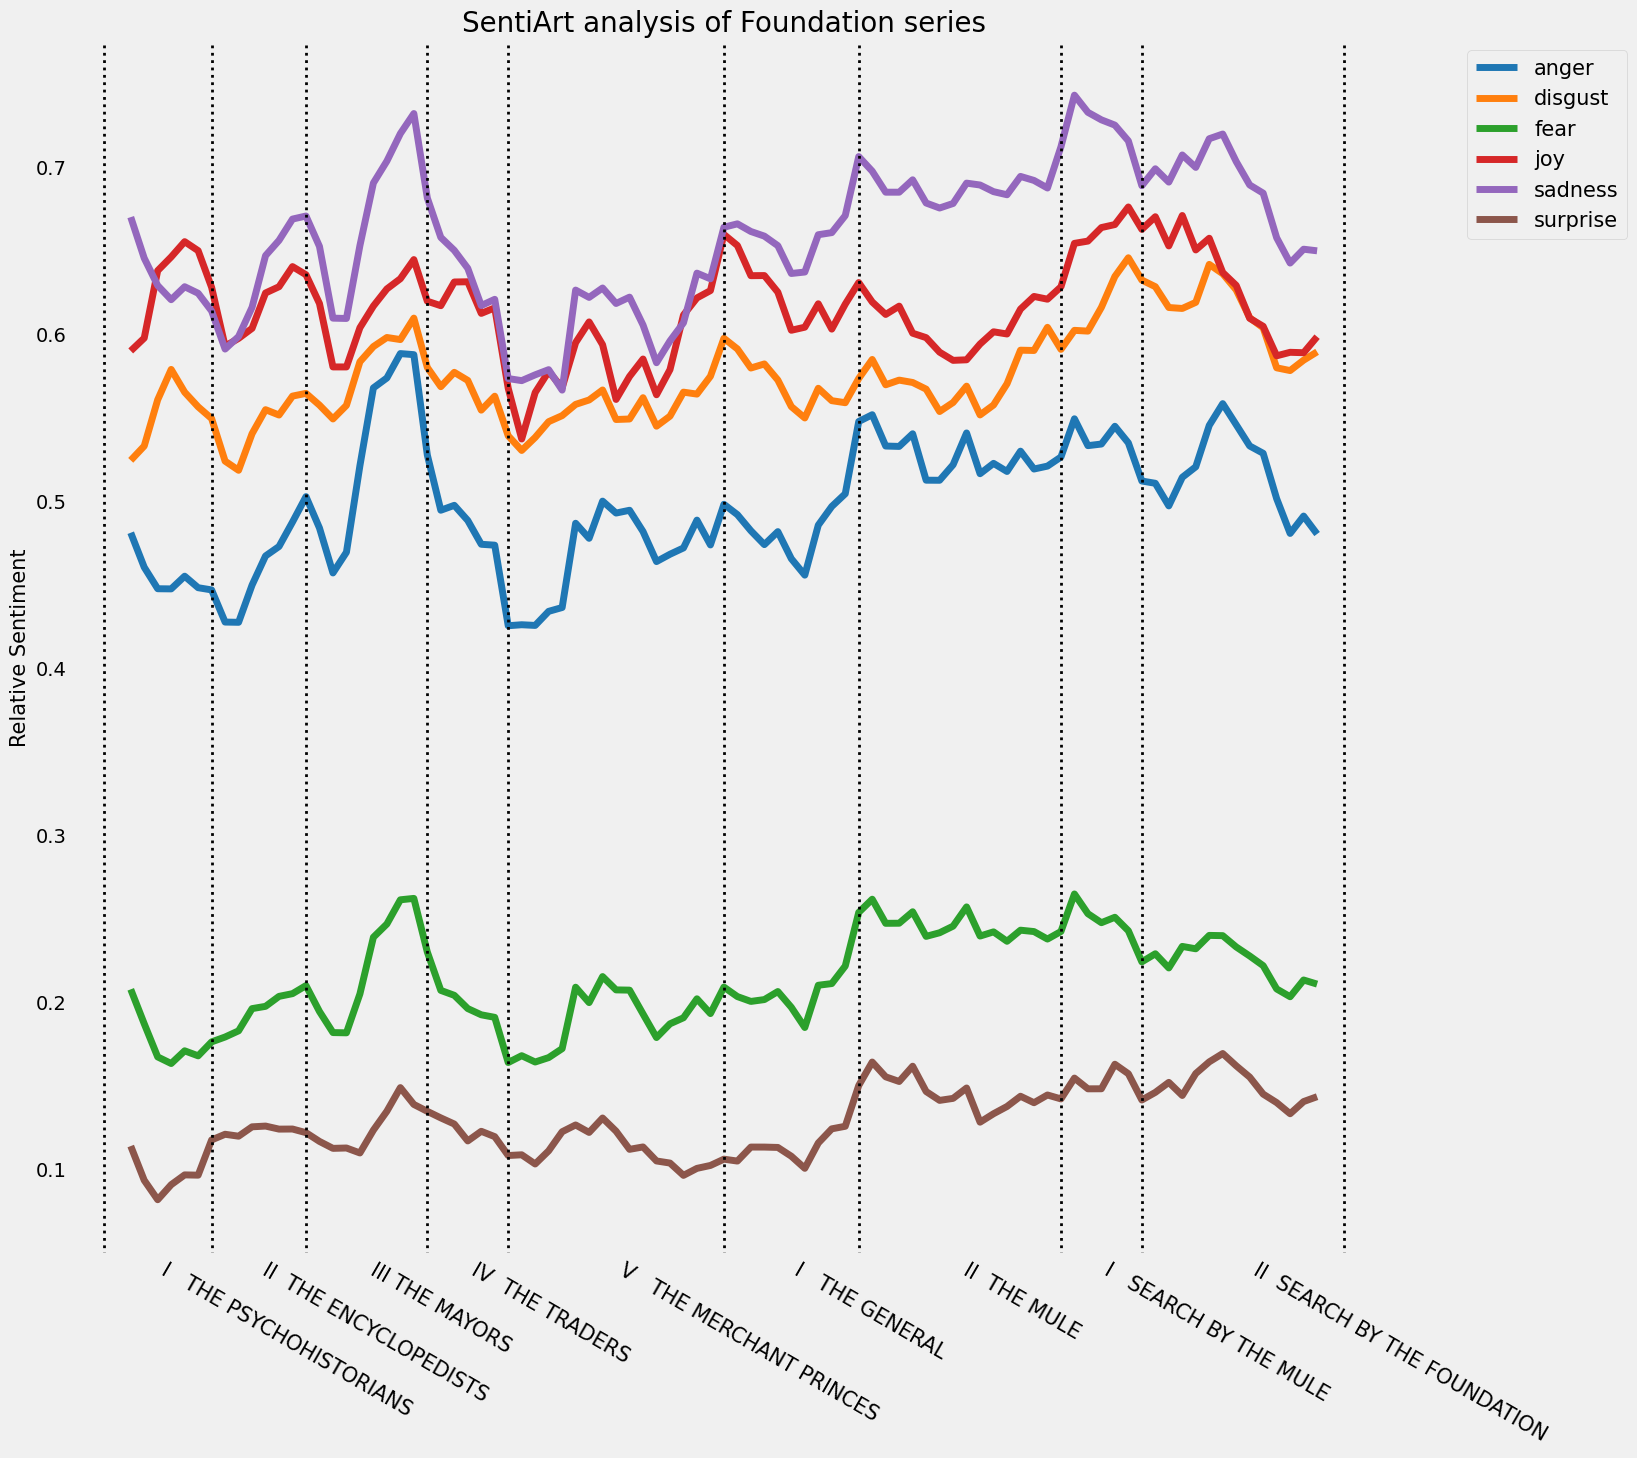

In [20]:
plot_multiple_emotions_window(sa_df, legend, sa_emotions, title=f'SentiArt analysis of {series.title}')

In [21]:
for emotion in set(nrc_emotions) & set(sa_emotions):
    corr = pd.Series([row[emotion] for _, row in nrc_df.iterrows()]).corr(pd.Series([row[emotion] for _, row in sa_df.iterrows()]))
    print(f'{emotion}\t\t{corr}')

joy		0.1952124776013005
fear		0.3167124494685333
disgust		0.2023292536443226
sadness		0.3271468799282618
anger		0.4785358670228417
surprise		0.13574134041160224
